<a href="https://colab.research.google.com/github/swtb3/llm_gpu_tokens_per_second_estimator/blob/main/tokens_per_second_estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tokens Per Second Estimator

Select a preset GPU or set preset to "Custom" and enter your own custom GPU details

GPU Specs:
GPU: NVIDIA V100
Effective Compute Throughput: 120 TFLOPS
Memory Bandwidth: 900 GB/s
FlashAttention Efficiency Factor: 0

Estimated Tokens Per Second (TPS):

 Model Size (B) Precision  Compute-bound TPS  Memory-bound TPS  Effective TPS
              7      fp16           8,571.43             32.14          32.14
             14      fp16           4,285.71             16.07          16.07
             32      fp16           1,875.00              7.03           7.03
             70      fp16             857.14              3.21           3.21
            200      fp16             300.00              1.12           1.12
              7      int8           8,571.43             64.29          64.29
             14      int8           4,285.71             32.14          32.14
             32      int8           1,875.00             14.06          14.06
             70      int8             857.14              6.43           6.43
            200      int8             300.00       

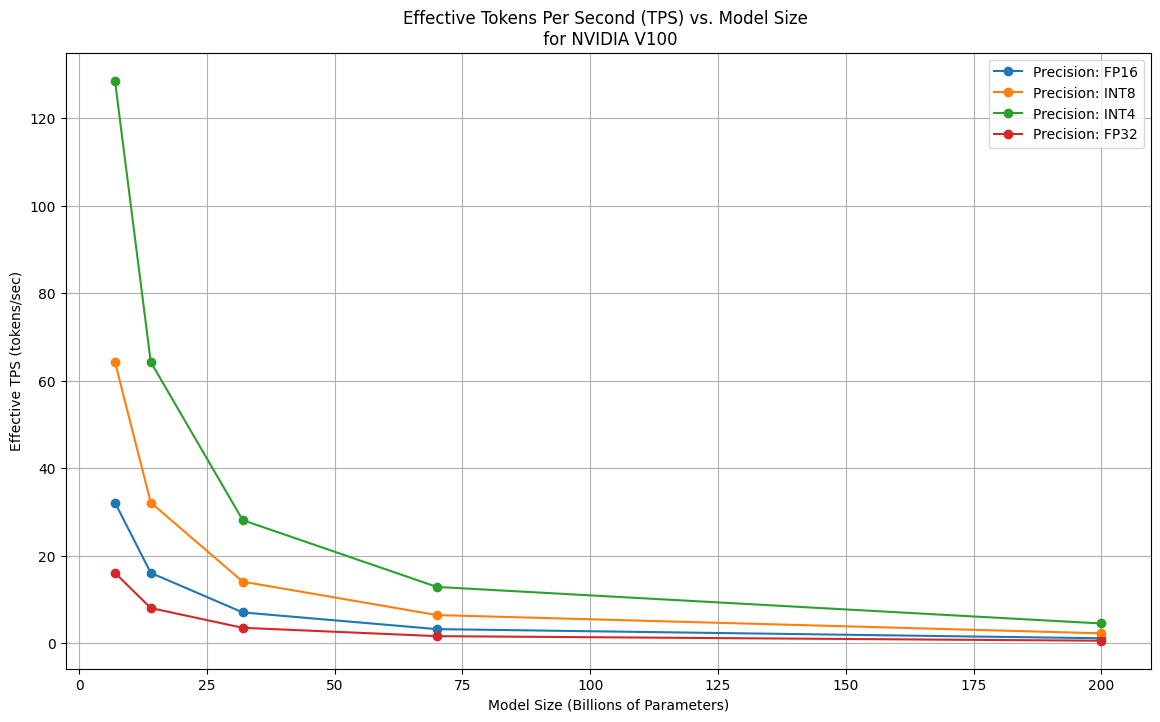

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def estimate_tps(model_size_billion, precision="fp16",
                 effective_compute=2.5e14,  # effective compute throughput in ops/s
                 memory_bandwidth=273e9,    # memory bandwidth in bytes/s
                 flash_attention_efficiency=0.65):
    """
    Estimate tokens per second (TPS) on a given system,
    taking into account both compute and memory bandwidth bottlenecks,
    and optionally incorporating the benefits of FlashAttention.

    Parameters:
      model_size_billion: Model parameter count in billions.
      precision: Quantization type. Options: "fp32", "fp16", "int8", "int4".
      effective_compute: Effective compute throughput in ops/s.
      memory_bandwidth: Effective memory bandwidth in bytes/s.
      flash_attention_efficiency: A factor (0 to 1) that scales the memory cost.
                                  For FlashAttention-3, a safe bet is around 0.65.

    Returns:
      (tps_compute, tps_memory, effective_tps)
    """
    # Define bytes per parameter for different quantizations.
    # fp32: 4 bytes; fp16: 2 bytes; int8: 1 byte; int4: 0.5 bytes.
    precision_to_bytes = {
        "fp32": 4,
        "fp16": 2,
        "int8": 1,
        "int4": 0.5
    }

    if precision not in precision_to_bytes:
        raise ValueError("Unsupported precision. Choose from 'fp32', 'fp16', 'int8', 'int4'.")

    bytes_per_param = precision_to_bytes[precision]
    num_params = model_size_billion * 1e9  # total number of parameters

    # Compute-bound estimation:
    # Assume each token requires 2 FLOPs per parameter.
    flops_per_token = 2 * num_params
    time_per_token_compute = flops_per_token / effective_compute  # seconds per token
    tps_compute = 1 / time_per_token_compute

    # Memory-bound estimation:
    # Without FlashAttention, bytes per token = 2 * (bytes per parameter) * num_params.
    # With FlashAttention, we scale this by flash_attention_efficiency.
    bytes_per_token = 2 * bytes_per_param * num_params * (1- flash_attention_efficiency)
    time_per_token_memory = bytes_per_token / memory_bandwidth  # seconds per token
    tps_memory = 1 / time_per_token_memory

    # Effective TPS is the bottleneck (the lower value)
    effective_tps = min(tps_compute, tps_memory)

    return tps_compute, tps_memory, effective_tps

def generate_report(gpu_specs):
    """
    Generate a comprehensive report on the estimated TPS for various model sizes and precisions.

    Parameters:
      gpu_specs: Dictionary containing 'name', 'effective_compute' (in TFLOPS), and 'memory_bandwidth' (in GB/s).
      flash_attention_efficiency: Efficiency factor for FlashAttention (0 to 1).
    """
    # Convert GPU specs to appropriate units:

    name = gpu_specs['name']
    effective_compute = gpu_specs['effective_compute'] * 1e12  # Convert TFLOPS to FLOPS
    memory_bandwidth = gpu_specs['memory_bandwidth'] * 1e9     # Convert GB/s to bytes/s
    flash_attention_efficiency = gpu_specs['flash_attention_efficiency']
    # List of model sizes (in billions of parameters)
    model_sizes = [7, 14, 32, 70, 200]
    # List of precisions to test
    precisions = ["fp16", "int8", "int4", "fp32"]

    print("GPU Specs:")
    print(f"GPU: {gpu_specs['name']}")
    print(f"Effective Compute Throughput: {gpu_specs['effective_compute']} TFLOPS")
    print(f"Memory Bandwidth: {gpu_specs['memory_bandwidth']} GB/s")
    print(f"FlashAttention Efficiency Factor: {flash_attention_efficiency}")
    print("\nEstimated Tokens Per Second (TPS):\n")

    results = []  # list to hold result dictionaries

    for precision in precisions:
        for model in model_sizes:
            tps_compute, tps_memory, effective_tps = estimate_tps(
                model, precision, effective_compute, memory_bandwidth, flash_attention_efficiency)
            results.append({
                "Model Size (B)": model,
                "Precision": precision,
                "Compute-bound TPS": tps_compute,
                "Memory-bound TPS": tps_memory,
                "Effective TPS": effective_tps
            })

    # Convert list of dictionaries to DataFrame
    df_results = pd.DataFrame(results)
    pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
    show_results_table = True  # @param {type:"boolean"}
    if show_results_table:
        print(df_results.to_string(index=False))

    # Plot the results
    plt.figure(figsize=(14, 8))
    for precision in precisions:
        subset = df_results[df_results["Precision"] == precision]
        plt.plot(subset["Model Size (B)"], subset["Effective TPS"], marker='o', label=f'Precision: {precision.upper()}')

    plt.title(f'Effective Tokens Per Second (TPS) vs. Model Size \n for {name}')
    plt.xlabel('Model Size (Billions of Parameters)')
    plt.ylabel('Effective TPS (tokens/sec)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Preset options
PRESET_GPU = "NVIDIA V100"  # @param ["NVIDIA DKX Spark", "NVIDIA T4", 'NVIDIA H200', 'NVIDIA H100', 'NVIDIA A100', 'NVIDIA A40', 'NVIDIA A10', 'NVIDIA V100', 'NVIDIA P4', 'NVIDIA RTX 3090', 'NVIDIA RTX 4090', 'Apple M4 Max', 'AMD Radeon RX 7900 XTX', 'Custom']

# Custom GPU fields (only used if "Custom" is selected)
custom_name = "My Custom GPU"  # @param {type:"string"}
custom_compute = 10000  # @param {type:"integer"} in TFLOPS (TerraFLOPS)
custom_bandwidth = 10000  # @param {type:"integer"} In GB/S
custom_flash_attention_efficiency = 0.65  # @param {type:"number"}

gpu_specs = {
    "NVIDIA DKX Spark": {
        "name": "NVIDIA DKX Spark",
        "effective_compute": 1000,
        "memory_bandwidth": 273,
        "flash_attention_efficiency": 0.65
    },
    "NVIDIA T4": {
        "name": "NVIDIA T4",
        "effective_compute": 65,         # ~300 TFLOPS (FP16 tensor, with sparsity benefits assumed)
        "memory_bandwidth": 320,         # ~4.8 TB/s = 4800 GB/s
        "flash_attention_efficiency": 0
    },
    "NVIDIA H200": {
        "name": "NVIDIA H200",
        "effective_compute": 300,         # ~300 TFLOPS (FP16 tensor, with sparsity benefits assumed)
        "memory_bandwidth": 4800,         # ~4.8 TB/s = 4800 GB/s
        "flash_attention_efficiency": 0.65
    },
    "NVIDIA H100": {
        "name": "NVIDIA H100",
        "effective_compute": 205,         # ~205 TFLOPS (FP16 tensor)
        "memory_bandwidth": 2039,         # ~2039 GB/s (PCIe version)
        "flash_attention_efficiency": 0.65
    },
    "NVIDIA A100": {
        "name": "NVIDIA A100",
        "effective_compute": 312,         # ~312 TFLOPS (FP16 tensor)
        "memory_bandwidth": 1555,         # ~1555 GB/s (for the 40GB model)
        "flash_attention_efficiency": 0.65
    },
    "NVIDIA A40": {
        "name": "NVIDIA A40",
        "effective_compute": 113,         # ~113 TFLOPS (approx. FP16 tensor)
        "memory_bandwidth": 696,          # ~696 GB/s
        "flash_attention_efficiency": 0.65
    },
    "NVIDIA A10": {
        "name": "NVIDIA A10",
        "effective_compute": 125,         # ~125 TFLOPS (FP16 tensor)
        "memory_bandwidth": 600,          # ~600 GB/s
        "flash_attention_efficiency": 0.65
    },
    "NVIDIA V100": {
        "name": "NVIDIA V100",
        "effective_compute": 120,         # ~120 TFLOPS (FP16 tensor)
        "memory_bandwidth": 900,          # ~900 GB/s
        "flash_attention_efficiency": 0
    },
    "NVIDIA P4": {
        "name": "NVIDIA P4",
        "effective_compute": 22,          # ~22 TFLOPS (FP16 tensor, low-power inference)
        "memory_bandwidth": 192,          # ~192 GB/s
        "flash_attention_efficiency": 0
    },
    "NVIDIA RTX 3090": {
        "name": "NVIDIA RTX 3090",
        "effective_compute": 285,         # ~285 TFLOPS (FP16 tensor with sparsity)
        "memory_bandwidth": 936,          # ~936 GB/s
        "flash_attention_efficiency": 0.65
    },
    "NVIDIA RTX 4090": {
        "name": "NVIDIA RTX 4090",
        "effective_compute": 330,         # ~330 TFLOPS (FP16 tensor with sparsity)
        "memory_bandwidth": 1018,         # ~1018 GB/s
        "flash_attention_efficiency": 0.65
    },
    "Apple M4 Max": {
        "name": "Apple M4 Max",
        "effective_compute": 18.4,        # ~18.4 TFLOPS (FP32 performance of the integrated GPU)
        "memory_bandwidth": 546,          # ~546 GB/s (unified memory bandwidth)
        "flash_attention_efficiency": 0
    },
    "AMD Radeon RX 7900 XTX": {
        "name": "AMD Radeon RX 7900 XTX",
        "effective_compute": 61,          # ~61 TFLOPS (FP32 performance)
        "memory_bandwidth": 960,          # ~960 GB/s
        "flash_attention_efficiency": 0.65
    }
}


# Select GPU based on user choice
if PRESET_GPU in gpu_specs.keys():
    selected_gpu = gpu_specs[PRESET_GPU]
else:  # Custom GPU
    selected_gpu = {
        "name": custom_name,
        "effective_compute": custom_compute,
        "memory_bandwidth": custom_bandwidth,
        "flash_attention_efficiency": custom_flash_attention_efficiency
    }

generate_report(selected_gpu)


In [ ]:
df_results

NameError: name 'df_results' is not defined